<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center>Week 4.  Classification algorithms comparison

Finally, we are going to train classification models, compare several algorithms via cross-validation, and figure out which session's parameters (*session_length* и *window_size*) it is better to use. Also, for the chosen algorithm, we will plot learning curves (which show the dependecy of model performance on the amount of training data) and validation curves (which show the dependency of model performance on one of it's hyperparameters).

**Week 4 roadmap:**
- Part 1. Different algorithms comparison on sessions of 10 websites
- Part 2. Hyperparameter tuning – session_length and window_size
- Part 3. Particular user identification and learning curves

**You might find following links useful:**
   - [Hyperparameter Optimization in Machine Learning Models](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models)
   - [Optimizing your model with cross-validation](http://blog.kaggle.com/2015/06/29/scikit-learn-video-7-optimizing-your-model-with-cross-validation/)

**Your task**
1. Fill in code in provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/10kYgawyf9kId7VDOnBhQ6PH64rU2HR0CmTy5CDwy2Vo)

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
scipy 1.1.0
pandas 0.23.0
matplotlib 2.2.2
statsmodels 0.9.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Change the path to data
PATH_TO_DATA = './capstone_user_identification/'

## Part 1. Different algorithms comparison on sessions of 10 websites

**Load *X_sparse_10users* and *y_10users* objects serialized earlier, which correspond to 10 users data.**

In [5]:
#You might wanna check the `encoding` param if you face any error while opening the .pkl files..
with open(os.path.join(PATH_TO_DATA, "picklefiles",
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, "picklefiles",
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**There are more than 14 thousand sessions and almost 5 thousand unique websites.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

In [7]:
X_sparse_10users.shape

(14061, 4913)

**Split the data into two parts. We are going to use the first part for cross-validation, second part will be used to evaluate performance of the model that we will end up with after cross-validation.**

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Define cross-validation: 3-fold, with shuffle, random_state=17 – for reproducibility.**

In [9]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Utility function to plot validation curves after running `GridSearchCV` (or `RandomizedCV`).**

In [10]:
def plot_validation_curves(param_values, grid_cv_results_):
    
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Train `KNeighborsClassifier` with 100 nearest neighbours (leave other parameters default values, only set `n_jobs = -1` for parallelization) and compare model's mean accuracy during 3-fold cross-validation (for reproducibility use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)
knn.fit(X_train,y_train)
accuracy_score(y_valid,knn.predict(X_valid))

0.584024650391088

In [14]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)
cross_val_score(knn,X_train,y_train,cv=skf).mean()

0.5647188870063362

**<font color='red'>Question 1. </font> Evaluate KNeighborsClassifier's mean accuracy during cross-validation and model's accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [16]:
#0.565,0.584

**2. Train a random forest (`RandomForestClassifier`) consisting of 100 trees (for reproducibility use `random_state`=17). Compare model's OOB-score on and its accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
forest = RandomForestClassifier(n_estimators=100, random_state=17,oob_score=True, n_jobs=-1)
forest.fit(X_train,y_train)
accuracy_score(y_valid,forest.predict(X_valid))

0.7312159279450107

**<font color='red'>Question 2. </font> Evaluate `RandomForestClassifier` Out-of-Bag aka OOB score and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [19]:
forest.oob_score_

0.7172322698638488

**3. Train logistic regression with default C value and `random_state`=17. Compare model's mean accuracy during 3-fold cross-validation (don't forget to use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [13]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
cross_val_score(logit,X_train,y_train, cv=skf).mean()

0.7610267543665875

In [14]:
logit.fit(X_train,y_train)
accuracy_score(y_valid,logit.predict(X_valid))

0.7817018250770325

**Read the documentation for [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Logistic regression is well studied and there are algorithms for fast parameter `C` search (faster than using `GridSearchCV`).**

**Using `LogisticRegressionCV` find optimal C value. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `logspace` from `NumPy`. Specify `multi_class`='multinomial' and `random_state`=17 for `LogisticRegressionCV`. For cross-validation use `skf` object created earlier. Use `n_jobs`=-1 for parallelization.**

**Plot validation curves for parameter `C`.**

In [15]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1,random_state=17, multi_class='multinomial',cv=skf) 
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 29.2 s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [18]:
logit_grid_searcher1.scores_[1]

array([[0.32511416, 0.47305936, 0.54885845, 0.64414003, 0.70197869,
        0.74398782, 0.75190259, 0.74672755, 0.73972603, 0.73028919],
       [0.32662397, 0.47819457, 0.56084172, 0.66056725, 0.72766087,
        0.76395242, 0.76974687, 0.76700213, 0.76059774, 0.74778896],
       [0.30292862, 0.46888347, 0.54850519, 0.64887126, 0.70927395,
        0.7461867 , 0.75533862, 0.75686394, 0.7495424 , 0.74039048]])

In [21]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1].mean(axis=0)

In [22]:
logit_mean_cv_scores1

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75899603, 0.75686454, 0.74995539, 0.73948955])

In [24]:
logit_mean_cv_scores1

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75899603, 0.75686454, 0.74995539, 0.73948955])

**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [20]:
logit_grid_searcher1.Cs_

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [28]:
np.max(logit_mean_cv_scores1),logit_c_values1[np.argmax(logit_mean_cv_scores1)]

(0.758996027558808, 1.0)

**Plot Accuracy vs. `C` dependency graph on cross-validation.**

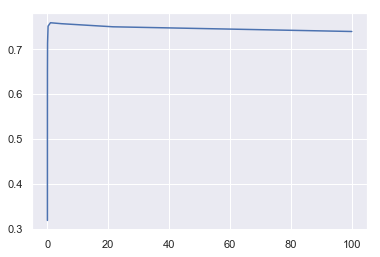

In [23]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Now, do the same again but search `C` values in range `np.linspace`(0.1, 7, 20). Plot the validation curves and find the best accuracy on cross-validation.**

In [24]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2,random_state=17, multi_class='multinomial',cv=skf) 
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 21s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [25]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1].mean(axis=0)
logit_mean_cv_scores2

array([0.7354267 , 0.75868969, 0.75858949, 0.75787777, 0.7580817 ,
       0.75787907, 0.75798091, 0.75757466, 0.7570673 , 0.75686494,
       0.75716964, 0.75666178, 0.75595074, 0.75574792, 0.75524069,
       0.75483505, 0.75442873, 0.75463214, 0.75453089, 0.75381935])

**Print the best accuracy on cross-validation and corresponding value of C.**

In [26]:
np.max(logit_mean_cv_scores2),logit_c_values2[np.argmax(logit_mean_cv_scores2)]

(0.7586896943864367, 0.4631578947368421)

**Plot Accuracy vs. `C` dependency graph on cross-validation.**

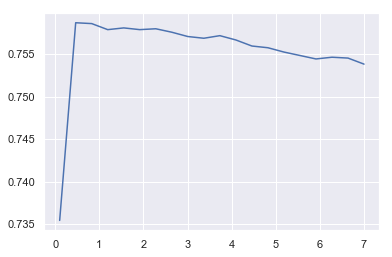

In [27]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

**Print logistic regressoin's accuracy with the best `C` value on `(X_valid, y_valid)`.**

In [28]:
logit_cv_acc = accuracy_score(y_valid,logit_grid_searcher2.predict(X_valid))

In [29]:
logit_cv_acc

0.7748281583313581

In [35]:
logit_cv_acc

0.7748281583313581

**<font color='red'>Question 3. </font> Evaluate model's mean accuracy for `logit_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [54]:
#0.7586896943864367, #0.7748281583313581

**4. Train SVM (`LinearSVC`) with `C`=1 and `random_state`=17. Compare model's mean accuracy during cross-validation (don't forget to use `skf` object) and model's ccuracy on `(X_valid, y_valid)`.**

In [3]:
from sklearn.svm import LinearSVC

In [56]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train,y_train)
accuracy_score(y_valid,svm.predict(X_valid))

0.7769613652524295

In [59]:
cross_val_score(svm, X_train,y_train,cv=skf, n_jobs=-1).mean()

0.7527976723012523

**Using `GridSearchCV` find optimal C value for SVM. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `linspace` from NumPy. Plot the validation curves.**

In [60]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm,svm_params1,n_jobs=-1,cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 47.7 s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [63]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.6845153424100793, {'C': 3333.3334000000004})

**Plot Accuracy vs. C dependency graph on cross-validation.**

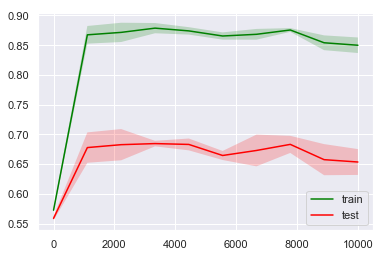

In [64]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**But we remember that using deafault regularization parameter (`C`=1) on cross-validation we get a higher accuracy. That's the case (not rare) of a possibility to make a mistake and searching parameters in a wrong range (the reason is that we took a uniform grid on a large scale and missed optimal interval of `C` values). It is more meaningful to search `C` near 1, in addition, model trains faster than with higher values of `C`.**

**Using `GridSearchCV` find optimal `C` value for SVM in range(1e-3, 1), 30 values, use `linspace` from NumPy. Plt the validation curves.**

In [8]:
%%time
svm = LinearSVC(C=1, random_state=17)
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm,svm_params2,n_jobs=-1,cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 10s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [9]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.764681975208291, {'C': 0.10434482758620689})

**Plot Accuracy vs. C dependency graph on cross-validation.**

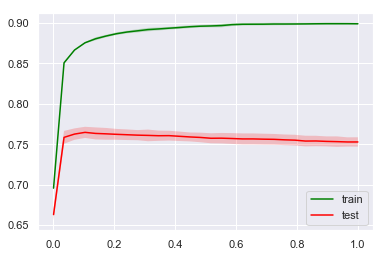

In [67]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**Print `LinearSVC`'s accuracy with the best `C` value on (X_valid, y_valid).**

In [71]:
svm_cv_acc = accuracy_score(y_valid,svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.7807537331121118

**<font color='red'>Question 4. </font> Evaluate model's mean accuracy for `svm_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [ ]:
#0.764681975208291, #0.7807537331121118

## Part 2. Parameter tuning – session_length and window_size

**Let's take `LinearSVC` since it performed best on cross-validation in part 1 and check its performance on 8 datasets of 10 users (with different combiantions of `session_length` and `window_size`). Since there are much more computations, we will not search regularization parameter `C` each time.**

**Write the `model_assessment` function with the specification provided below. Pay your attention to all details, e.g. `train_test_split` should be stratified. Don't forget `random_state` anywhere.**

In [11]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start_time = time()
    #You might wanna check the `encoding` param if you face any error while opening the .pkl files..
    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse_users = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y_users = pickle.load(y_users_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_users, y_users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_users)
    estimator.fit(X_train,y_train)
    
    cv_score, acc_score = cross_val_score(estimator,X_train,y_train,cv=cv).mean(), accuracy_score(y_valid,estimator.predict(X_valid))
    
    total_time = time()-start_time
    return  cv_score, acc_score, total_time

**Double-check that the function is working.**

In [84]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7646853244550981, 0.7807537331121118, 2.2375643253326416)

**Apply `model_assessment` function for the best algorithm from the previous part (namely, `svm_grid_searcher2.best_estimator_`) and 9 datasets with different combinations of `session_length` and `window_size` of 10 users. Print `session_length` and `window_size` parameters in the loop as well as an output of the `model_assessment` function.
It's handy if the `model_assessment` function returns execution time as a third output argument. It took 20 sec to execute this code snippet on my laptop. But with 150 users dataset, each iteration takes a couple of minutes.**

Here, for the convinience it worth to create copies of pickle-files `X_sparse_10users.pkl`, `X_sparse_150users.pkl`, `y_10users.pkl` and `y_150users.pkl` adding `s10_w10` to their names, which means session length of 10 and window width of 10.

In [ ]:
# Won't work on non-Linux based Machines (Basically it's creating copies of the files)
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [86]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,'X_sparse_10users_s{}_w{}.pkl'.format(session_length,window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA,'y_10users_s{}_w{}.pkl'.format(session_length,window_size))
        
        cv_acc, acc_val, time_taken = model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
        
        print ('session_length:{} window_size:{} mean_cv_acc:{} acc_val:{} time:{}'.format(session_length,window_size,cv_acc,acc_val,time_taken))      

session_length:15 window_size:10 mean_cv_acc:0.8238214955278105 acc_val:0.8404835269021095 time:4.855405330657959
session_length:10 window_size:10 mean_cv_acc:0.7646853244550981 acc_val:0.7807537331121118 time:2.3681576251983643
session_length:15 window_size:7 mean_cv_acc:0.8479403769844098 acc_val:0.8543222166915547 time:5.913271903991699
session_length:10 window_size:7 mean_cv_acc:0.7970161463734652 acc_val:0.8073668491786958 time:3.825791597366333
session_length:7 window_size:7 mean_cv_acc:0.7529891114830342 acc_val:0.7617388418782147 time:2.262112855911255
session_length:15 window_size:5 mean_cv_acc:0.868001372554347 acc_val:0.8752963489805595 time:8.573070526123047
session_length:10 window_size:5 mean_cv_acc:0.8159247205318039 acc_val:0.8245614035087719 time:6.552319288253784
session_length:7 window_size:5 mean_cv_acc:0.774058674563226 acc_val:0.7853247984826932 time:2.6269519329071045
session_length:5 window_size:5 mean_cv_acc:0.7252830650398828 acc_val:0.7362494073020389 time:1.

**<font color='red'>Question 5. </font> Evaluate `LinearSVC`'s accuracy  with optimal `C` on `X_sparse_10users_s15_w5` dataset. Write model's mean accuracy on cross-validation and its accuracy on validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [10]:
# mean_cv_acc:0.868001372554347 acc_val:0.8752963489805595

**Comment on the results. Compare mean accuracy on cross-validation and on validation dataset using the following combinations of parameters(`session_length, window_size`): (5,5), (7,7) и (10,10). On average laptop it could take up to an hour. After all, it's data science :)**.

**Make a conclusion about how accuracy depends on session length and window width.**

In [12]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA,'X_sparse_150users_s{}_w{}.pkl'.format(session_length,window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA,'y_150users_s{}_w{}.pkl'.format(session_length,window_size))

    cv_acc, acc_val, time_taken = model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
    print ('session_length:{} window_size:{} mean_cv_acc:{} acc_val:{} time:{}'.format(session_length,window_size,cv_acc,acc_val,time_taken))      

session_length:5 window_size:5 mean_cv_acc:0.40858659509908596 acc_val:0.42171606560568453 time:458.21992087364197
session_length:7 window_size:7 mean_cv_acc:0.43638649409423974 acc_val:0.45295840855673264 time:424.82732629776
session_length:10 window_size:10 mean_cv_acc:0.4612588999427913 acc_val:0.4836276942538802 time:376.2286956310272
Wall time: 20min 59s


**<font color='red'>Question 6. </font> Evaluate `LinearSVC`'s accuracy with optimal `C` value on `X_sparse_150users`. Write model's accuracy on cross-validation and on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [13]:
#mean_cv_acc:0.4612588999427913 acc_val:0.4836276942538802

## Part 3. Particular user identification and learning curves

**Since it may dissapoint that accuracy at multiclass classification problem on 150 users dataset is low, let's joy the fact that some particular user could be identified quite well.**

**Load `X_sparse_150users` and `y_150users` objects serialized earlier which correspond to 150 users dataset with parameters (*session_length, window_size*) = (10,10). Split them into two parts: 70% train data and 30% validation data.**

In [30]:
with open(os.path.join(PATH_TO_DATA, "picklefiles",'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, "picklefiles",'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [31]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Train `LogisticRegressionCV` with single `C` value (take the best `C` value on cross-validation in part 1, use an accurate value, not an approximate one). Now we are going to solve 150 tasks One-vs-All, hence set `multi_class`='ovr'. As usual, set `n_jobs=-1` and `random_state`=17 where it is possible (this training might take up to 20 min).**

In [32]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs = [0.4631578947368421], multi_class='ovr', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 8min 20s


**Compare mean accuracy on cross-validation for each user identification problem separately.**

In [35]:
logit_cv_150users.scores_[1].mean()

0.995850217686121

In [44]:
logit_cv_150users.scores_[1].mean()

0.9958396485310578

In [36]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] =logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id,cv_scores_by_user[user_id]))

User 1, CV score: 0.995850217686121
User 2, CV score: 0.9962154692488628
User 3, CV score: 0.9951310537804167
User 4, CV score: 0.9915759824185644
User 5, CV score: 0.989886456818156
User 6, CV score: 0.9945366562081962
User 7, CV score: 0.9935672094050271
User 8, CV score: 0.9860393314979725
User 9, CV score: 0.9980607063671277
User 10, CV score: 0.9948599899870656
User 11, CV score: 0.9944221631139541
User 12, CV score: 0.9936091179828602
User 13, CV score: 0.9969347547292645
User 14, CV score: 0.9949642340422806
User 15, CV score: 0.9963612170153343
User 16, CV score: 0.9963509868624326
User 17, CV score: 0.9905331098557655
User 18, CV score: 0.9943387038465749
User 19, CV score: 0.9947556519752707
User 20, CV score: 0.9911796417927246
User 21, CV score: 0.979971783259702
User 22, CV score: 0.9968097113660846
User 23, CV score: 0.994463455185883
User 24, CV score: 0.9905019210479512
User 25, CV score: 0.9965177920804397
User 26, CV score: 0.9942136517514025
User 27, CV score: 0.9949

In [45]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] =logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id,cv_scores_by_user[user_id]))

User 1, CV score: 0.9958396485310578
User 2, CV score: 0.996236159606072
User 3, CV score: 0.9951414156621485
User 4, CV score: 0.9917629636028263
User 5, CV score: 0.990032646749408
User 6, CV score: 0.9945992933895361
User 7, CV score: 0.9936295923347456
User 8, CV score: 0.9857474441964414
User 9, CV score: 0.9979773735144889
User 10, CV score: 0.9949328849394247
User 11, CV score: 0.9944847392709221
User 12, CV score: 0.9936087227963695
User 13, CV score: 0.9969973347781819
User 14, CV score: 0.9949640742212859
User 15, CV score: 0.9963612639936241
User 16, CV score: 0.9963196987839488
User 17, CV score: 0.9905122649916512
User 18, CV score: 0.9943596252032839
User 19, CV score: 0.9947138940123931
User 20, CV score: 0.991190153815365
User 21, CV score: 0.9798259124963927
User 22, CV score: 0.9968201105460203
User 23, CV score: 0.9945051894225921
User 24, CV score: 0.9906581115547454
User 25, CV score: 0.9966011573912393
User 26, CV score: 0.9942028893690901
User 27, CV score: 0.994

**Accuracy could seem impressive, but, perhaps, we forget about class disbalance and high accuracy could just be obtained with a constant prediction.  Evaluate the difference between accuracy on cross-validation (we've just evaluated using `LogisticRegressionCV`) and the fraction of labels which differ from user_id (that's the accuracy we get if classificator always says that it is not the $i$-th user in classification task $i$-vs-All) for each user in `y_train_150`.**

In [37]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant ={}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1-class_distr[user_id]/len(y_train_150))

In [62]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant ={}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1-class_distr[user_id]/len(y_train_150))

In [38]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [39]:
num_better_than_default

134

In [64]:
num_better_than_default

137

**<font color='red'>Question 7. </font> Evaluate the fraction of users where `LogisticRegressionCV` performs better than just a constant prediction. Round your answer up to the third digit after the decimal point.**

In [40]:
134/150

0.8933333333333333

**Next step is to plot learning curves for a particular user, let's say for 128-th. Make a new binary vector using `y_150users`, its values are 1 or 0 depending on whether user_id=128 or not.**

In [69]:
y_binary_128 = (y_150users==128).astype(int)

In [71]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Evaluate accuracy on cross-validation at "user128-vs-All" task depending on train size. It would be useful to check the documentation for `learning_curve`.**

In [85]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, n_jobs=-1,cv=3,shuffle =True)

Wall time: 6.5 s


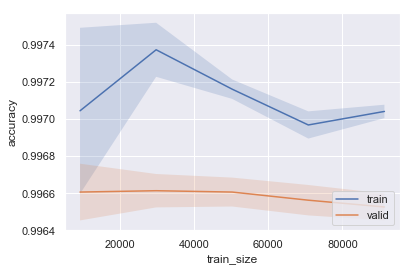

In [86]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Make a conclusion whether new data helps to improve the model's accuracy with the same problem definition.**

Next week, we will recall linear models trained with stochastic gradient descend, and enjoy how faster they work.